In [2]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')

import numpy as np
from analysis import collection, analysis, emg, plot, model
import scipy as sp
from pathlib import Path

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

import matplotlib.pyplot as plt

image_path = Path("/Users/spencer/phd/phd/images/more_results/gmms/")

%matplotlib inline

In [3]:
subjects = analysis.load_subjects()

In [4]:
subject_idx = 9

- look at GMM model covariances for one subject
- look at PCA results for the same log data used to fit the model -- sum of rank-1 covariance (comp @ comp.T)

In [5]:
models = model.load_log_trial_models(subject_idx)

/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator BayesianGaussianMixture from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
first_model = models[0]

In [7]:
stack = analysis.load_trial_stack(subject_idx=subject_idx)

In [8]:
sessions = stack[:9]

In [9]:
with_nans = sessions.transpose(0,1,3,2).reshape(-1,64)
print(with_nans.shape)
samples = analysis.remove_nan_rows(with_nans)
print(samples.shape)

(216000, 64)
(51397, 64)


### PCA on log samples

In [10]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(analysis.log_emg_data(samples))
pca_comps = pca.components_
pca_covs = np.array([c.reshape(-1,1) @ c.reshape(1,-1) for c in pca_comps])
print(pca_covs.shape)

(64, 64, 64)


In [11]:
model_covs = first_model.covariances_
model_covs.shape

(12, 64, 64)

In [12]:
weight_order = np.argsort(first_model.weights_)[::-1]
weight_order

array([ 8,  5,  0,  7, 10,  2,  1,  6, 11,  4,  3,  9])

Text(0.5, 168.7222222222222, 'EMG Channel')

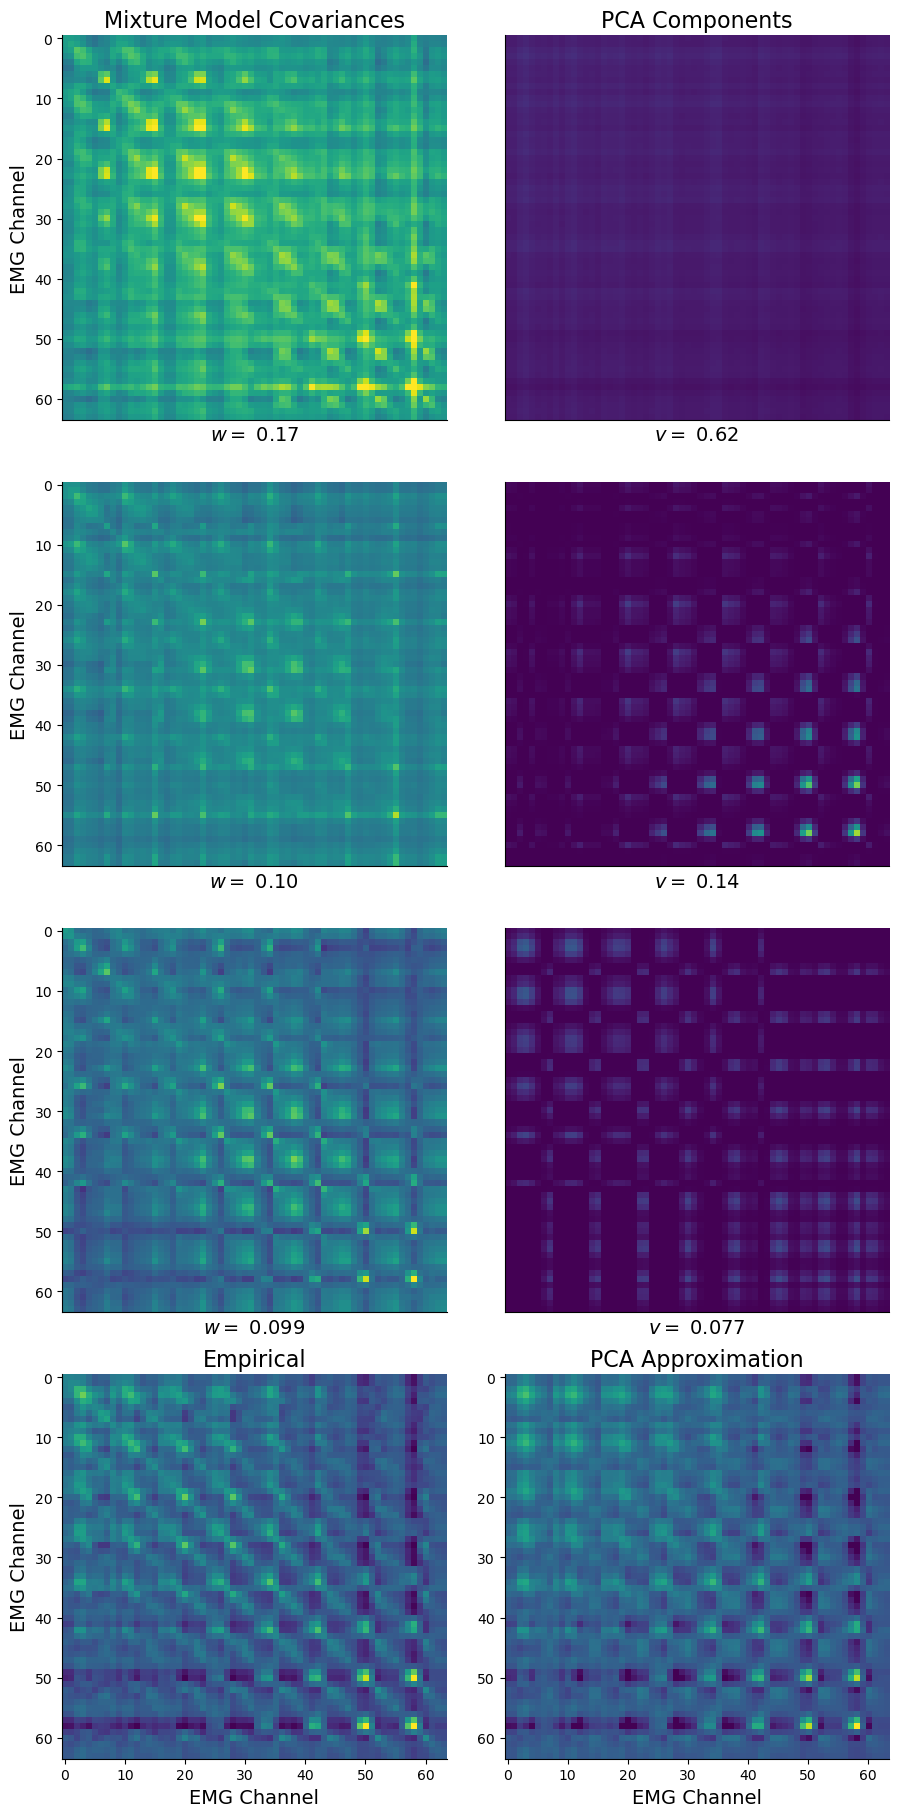

In [21]:
pca_fig, axes = plt.subplots(4,2,figsize=(9,18))
pca_fig.tight_layout()
sum = np.zeros_like(model_covs[0])
for axi, i in enumerate(weight_order[:3]):
    axes[axi,0].set_ylabel("EMG Channel",fontsize=14)
    axes[axi,0].imshow(model_covs[i],vmin=0,vmax=0.2)
    sum += model_covs[i]*first_model.weights_[i]
    axes[axi,0].set_xlabel(f"$w = $ {plot.format_positional(first_model.weights_[i])}",fontsize=14)
    axes[axi,0].set_xticks([])
axes[0,0].set_title("Mixture Model Covariances",fontsize=16)
axes[-1,0].imshow(np.cov(analysis.log_emg_data(samples).T),vmin=0,vmax=0.5)
axes[-1,0].set_title("Empirical",fontsize=16)
axes[-1,0].set_xlabel("EMG Channel",fontsize=14)
axes[-1,0].set_ylabel("EMG Channel",fontsize=14)

sum = np.zeros_like(pca_covs[0])
for i in range(64):
    if i < 3:
        axes[i,1].imshow(pca_covs[i],vmin=0,vmax=0.2)
        sum += pca_covs[i]*pca.explained_variance_[i]
        axes[i,1].set_xlabel(f"$v = $ {plot.format_positional(pca.explained_variance_ratio_[i])}",fontsize=14)
        axes[i,1].set_xticks([])
        axes[i,1].set_yticks([])
axes[0,1].set_title("PCA Components",fontsize=16)
axes[-1,1].imshow(sum,vmin=0,vmax=0.5)
axes[-1,1].set_title("PCA Approximation",fontsize=16)
axes[-1,1].set_xlabel("EMG Channel",fontsize=14)

In [22]:
plot.save_figure(pca_fig, "gmm_vs_pca",image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/gmm_vs_pca.pdf
